# Parental Leave Project
## Part I - Getting Data

I want to combine and manipulate data from several wikipedia pages and the OECD data sets. The most straightforward way to do this would be to scrape the data from the webpages and put it into csv's that I could then use import into python using the csv and pandas libraries. 

This ended up being easier than I expected, because I found a [post](https://roche.io/2016/05/scrape-wikipedia-with-python) by Andy Roche about this problem. 

I started out using the code verbatim from [Andy Roche's GitHub](https://github.com/rocheio/wiki-table-scrape/blob/master/wikitablescrape.py), but there was a problem with the [Parental Leave wikipedia page](https://en.wikipedia.org/wiki/Parental_leave) - the webpage has 5 tables and the code was only scraping 3 of them. 

The three tables that got scraped are: 
* Africa
* Americas
* Europe and Central Asia

The two that got missed are:
* Asia/Pacific
* United Nations

Upon inspecting the webpage, I realized that the two missing tables are not sort-able. In the other three tables, you can sort them in ascending an descending order for each of the columns by clicking on the arrow icon on the column heading. In contrast, the Asia/Pacific and United Nations tables, are not sortable. 

I looked more carefully at the HTML code from those two tables to see how it differs from the sortable tables. This is easy to do in Google Chrome by right clicking on the webpage and choosing "Inspect."

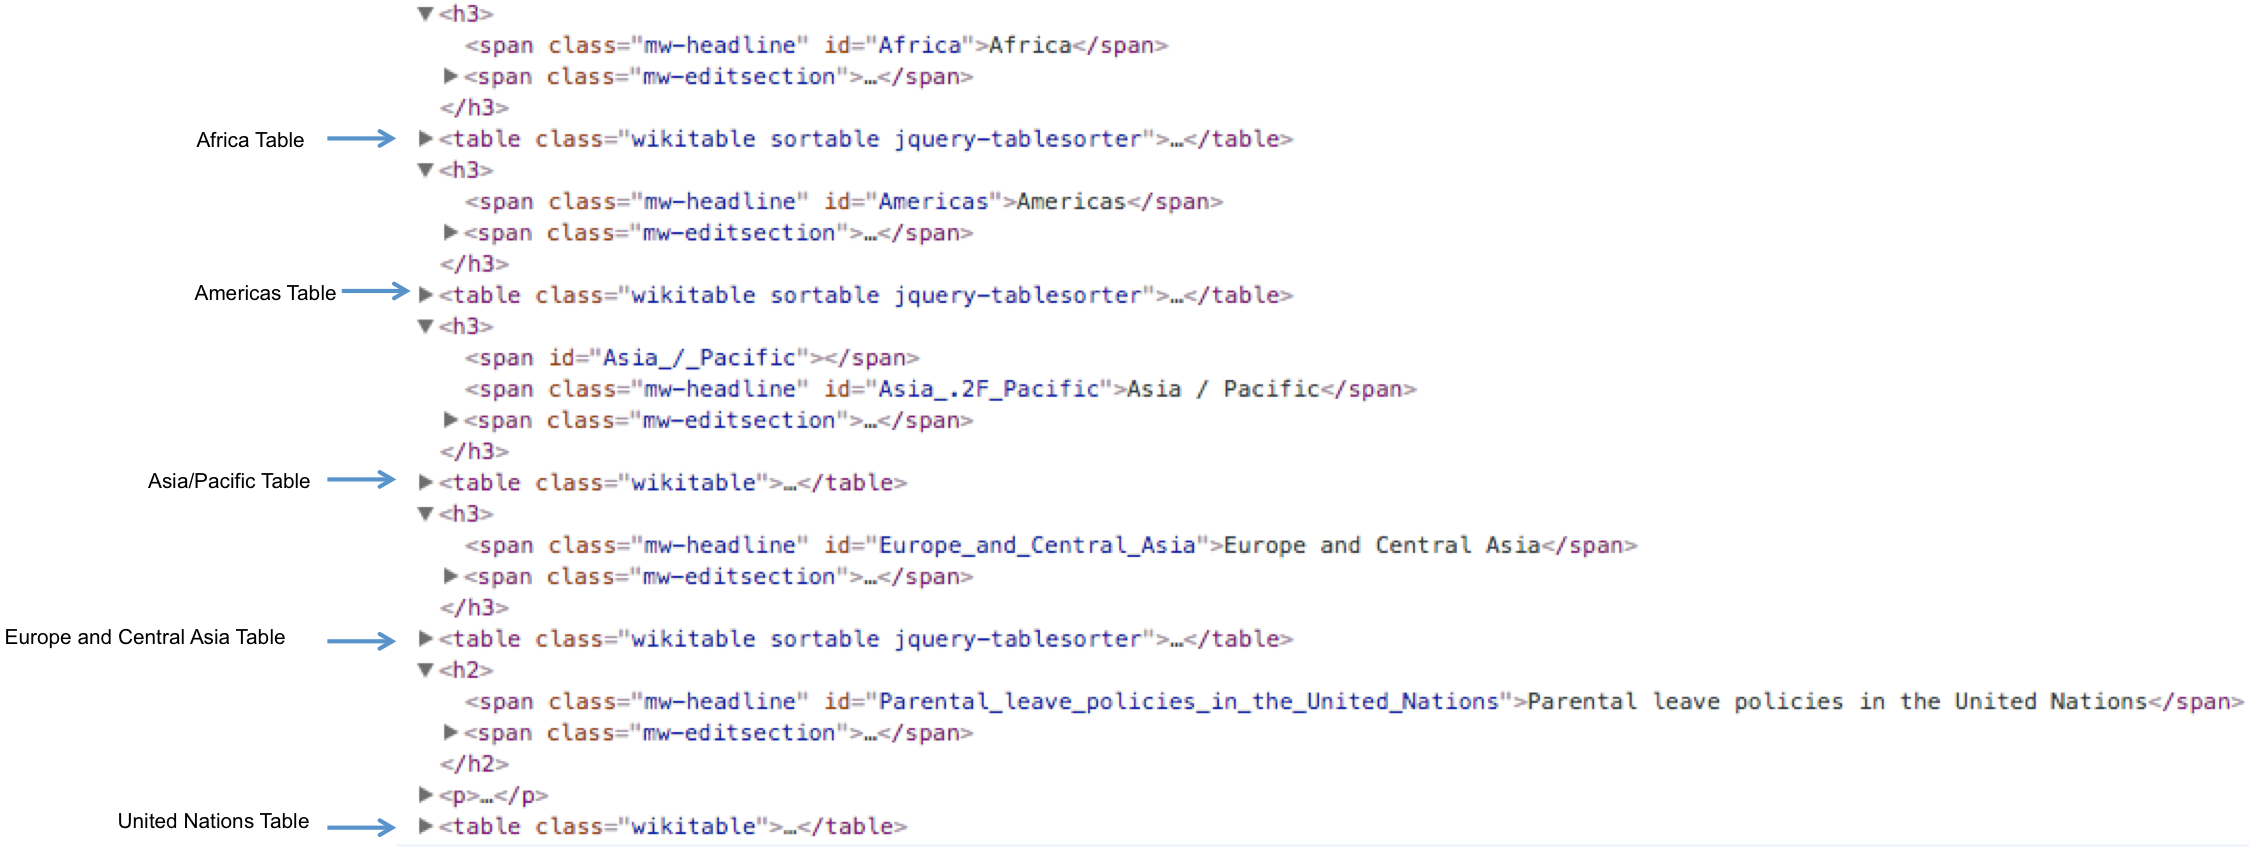

There are two types of tables - in the HTML they look like this:
* Sortable Tables
```html 
<table class="wikitable sortable jquery-tablesorter">
```
* Non-sortable tables
```html
<table class="wikitable">
```

I took a second look at Andy's scrape() function - there is some attempt to grab tables of different types. He uses the following lines of code to pick out the tables of interest:

``` python 
table_classes = {"class": ["sortable", "plainrowheaders"]}
wikitables = soup.findAll("table", table_classes)
```

I modifided his code to add the class "wikitable" to the list of table classes to scrape. 

``` python
table_classes = {"class": ["sortable", "plainrowheaders", "wikitable"]}
```

and ... 
Success! The code now succesfully scrapes all 5 tables from the Parental Leave webpage. 

In [1]:
import csv
import os
import platform

from bs4 import BeautifulSoup
import requests

In [2]:
def clean_data(row):
    """Clean table row list from Wikipedia into a string for CSV.
    ARGS:
        row (bs4.ResultSet): The bs4 result set being cleaned for output.
    RETURNS:
        cleaned_cells (list[str]): List of cleaned text items in this row.
    """

    cleaned_cells = []

    for cell in row:
        # Strip references from the cell
        references = cell.findAll("sup", {"class": "reference"})
        if references:
            for ref in references:
                ref.extract()

        # Strip sortkeys from the cell
        sortkeys = cell.findAll("span", {"class": "sortkey"})
        if sortkeys:
            for ref in sortkeys:
                ref.extract()

        # Strip footnotes from text and join into a single string
        text_items = cell.findAll(text=True)
        no_footnotes = [text for text in text_items if text[0] != '[']

        cleaned = (
            ''.join(no_footnotes)  # Combine elements into single string
            .replace('\xa0', ' ')  # Replace non-breaking spaces
            .replace('\n', ' ')  # Replace newlines
            .strip()
        )

        cleaned_cells += [cleaned]

    return cleaned_cells

In [3]:
def write_html_table_to_csv(table, writer):
    """Write HTML table from Wikipedia to a CSV file.
    ARGS:
        table (bs4.Tag): The bs4 Tag object being analyzed.
        writer (csv.writer): The csv Writer object creating the output.
    """

    # Hold elements that span multiple rows in a list of
    # dictionaries that track 'rows_left' and 'value'
    saved_rowspans = []
    for row in table.findAll("tr"):
        cells = row.findAll(["th", "td"])

        # If the first row, use it to define width of table
        if len(saved_rowspans) == 0:
            saved_rowspans = [None for _ in cells]
        # Insert values from cells that span into this row
        elif len(cells) != len(saved_rowspans):
            for index, rowspan_data in enumerate(saved_rowspans):
                if rowspan_data is not None:
                    # Insert the data from previous row; decrement rows left
                    value = rowspan_data['value']
                    cells.insert(index, value)

                    if saved_rowspans[index]['rows_left'] == 1:
                        saved_rowspans[index] = None
                    else:
                        saved_rowspans[index]['rows_left'] -= 1

        # If an element with rowspan, save it for future cells
        for index, cell in enumerate(cells):
            if cell.has_attr("rowspan"):
                rowspan_data = {
                    'rows_left': int(cell["rowspan"]),
                    'value': cell,
                }
                saved_rowspans[index] = rowspan_data

        if cells:
            # Clean the data of references and unusual whitespace
            cleaned = clean_data(cells)

            # Fill the row with empty columns if some are missing
            # (Some HTML tables leave final empty cells without a <td> tag)
            columns_missing = len(saved_rowspans) - len(cleaned)
            if columns_missing:
                cleaned += [None] * columns_missing

            writer.writerow(cleaned)

In [4]:
def scrape(url, output_name):
    """Create CSVs from all tables in a Wikipedia article.
    ARGS:
        url (str): The full URL of the Wikipedia article to scrape tables from.
        output_name (str): The base file name (without filepath) to write to.
    """

    # Read tables from Wikipedia article into list of HTML strings
    resp = requests.get(url)
    soup = BeautifulSoup(resp.content, 'lxml')
    table_classes = {"class": ["sortable", "plainrowheaders", "wikitable"]}
    wikitables = soup.findAll("table", table_classes)

    # Create folder for output if it doesn't exist
    try:
        os.mkdir(output_name)
    except Exception:  # Generic OS Error
        print('There was an error!')
        pass

    for index, table in enumerate(wikitables):
        # Make a unique file name for each CSV
        if index == 0:
            filename = output_name
        else:
            filename = output_name + '_' + str(index)

        filepath = os.path.join(output_name, filename) + '.csv'

        with open(filepath, mode='w', newline='', encoding='utf-8') as output:
            
            csv_writer = csv.writer(output,quoting=csv.QUOTE_ALL)
            
            write_html_table_to_csv(table, csv_writer)


In [5]:
scrape("https://en.wikipedia.org/wiki/List_of_minimum_annual_leave_by_country",'Annual Leave by Country')
scrape("https://en.wikipedia.org/wiki/World_economy", 'GDP by Country')
scrape('https://en.wikipedia.org/wiki/List_of_countries_by_employment_rate', 'Employment Rate By Country')
scrape('https://en.wikipedia.org/wiki/Parental_leave','Parental Leave By Country')
scrape('https://en.wikipedia.org/wiki/List_of_sovereign_states_and_dependencies_by_total_fertility_rate','Fertility Rate by Country')

I also downloaded a csv of employment rates broken down by country and gender from the [OECD website](http://www.oecd.org/gender/data/)